# Dataset Information Creation
Create a json file to represent the files inside the dataset

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import numpy as np
import json
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn
import os
import utils

In [2]:
# sudo modprobe nvidia_uvm
torch.cuda.is_available()

True

In [4]:
DATASET_NAME = "DATASET_CNN"
MODEL_NAME = 'DeeperCNN'

In [5]:
DATASET_PATH = f'../segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
TEST_PATH = f"{DATASET_PATH}/test"
MODEL_PATH = f'./models/{MODEL_NAME}'

# Create Dataset Config

In [ ]:
mappings = utils.get_mappings(TEST_PATH)
samples = utils.collect_samples(TRAIN_PATH, TEST_PATH, mappings)

In [9]:
dataset_config = {
    "mappings": mappings,
    "samples": samples
}

In [10]:
# with open(f"utils/{DATASET_NAME}/dataset_config.json", "w") as f:
#     json.dump(dataset_config, f)

## Load the model

In [ ]:
model_class = utils.load_model_class(MODEL_NAME)
model = model_class(len(mappings))

# Spectograms Creation

In [14]:
SPECS_TRAIN_PATH = f"{DATASET_PATH}/train_specs"
SPECS_TEST_PATH = f"{DATASET_PATH}/test_specs"
os.makedirs(SPECS_TRAIN_PATH, exist_ok=True)
os.makedirs(SPECS_TEST_PATH, exist_ok=True)
utils.specs_generation(TRAIN_PATH, SPECS_TRAIN_PATH, dataset_config['mappings'])
utils.specs_generation(TEST_PATH, SPECS_TEST_PATH, dataset_config['mappings'])

Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Glaucidium passerinum_Eurasian Pygmy-Owl
Processing: Troglodytes troglodytes_Eurasian Wren
Processing: Erithacus rubecula_European Robin
Processing: Dryocopus martius_Black Woodpecker
Processing: Certhia familiaris_Eurasian Treecreeper
Processing: Pyrrhula pyrrhula_Eurasian Bullfinch
Processing: Turdus merula_Eurasian Blackbird
Processing: Loxia curvirostra_Common Crossbill
Processing: Regulus ignicapilla_Common Firecrest
Processing: Dendrocopos major_Great Spotted Woodpecker
Processing: Sylvia atricapilla_Eurasian Blackcap
Processing: Lophophanes cristatus_Crested Tit
Processing: Fringilla coelebs_Common Chaffinch
Processing: Turdus philomelos_Song Thrush
Processing: Muscicapa striata_Spotted Flycatcher
Processing: Periparus ater_Coal Tit
Processing: Regulus regulus_Goldcrest
Processing: Glaucidium passerinum_Eurasian Pygmy-Owl
Processing: Troglodytes 

Shape: torch.Size([256, 256])


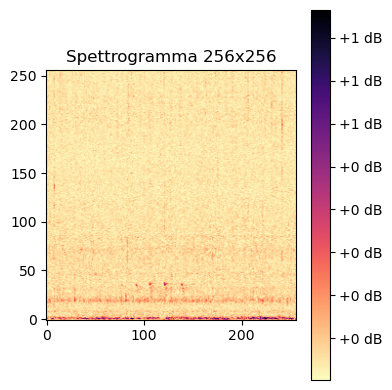

In [15]:
# carica lo spettrogramma salvato
spec_path = "/home/giacomoschiavo/segments/DATASET_CNN/train_specs/Turdus merula_Eurasian Blackbird/20190621_160000_64_5.pt"  # cambia path se serve
spec = torch.load(spec_path)

# controlla la shape per capire cosa stai guardando
print("Shape:", spec.shape)  # dovrebbe essere (256, 256)

# Plot semplice e clean
plt.figure(figsize=(4, 4))
plt.imshow(spec.numpy(), origin='lower', cmap='magma_r')
plt.title("Spettrogramma 256x256")
plt.colorbar(format="%+2.f dB")
plt.tight_layout()
plt.show()


# Model

In [16]:
def train_model(dataset_config, model, epochs=10, batch_size=100, lr=1e-5, patience=3, early_stop_patience=5, print_freq=100, load_weights=False):
    history_loss = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training {MODEL_NAME} on: {device}")

    print("Loading training data...")
    train_loader = utils.get_dataloader(dataset_config, split="train", batch_size=batch_size)
    print("Loaded!")

    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=patience, threshold=1e-3
    )
    history_loss = []
    best_loss = float("inf")

    saving_path = f'models/{MODEL_NAME}/checkpoint.pth'
    if load_weights:
        if not os.path.exists(saving_path):
            print("No weights found!")
            return None
        checkpoint = torch.load(saving_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        history_loss = checkpoint['history_loss']
        best_loss = checkpoint['avg_loss']
        
    early_stop_counter = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"\n🎯 Starting epoch {epoch + 1}/{epochs}")

        for batch_index, (mel_spec, labels, _) in enumerate(train_loader):
            mel_spec = mel_spec.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if batch_index % print_freq == 0:
                print('Epoch: [{0}][{1}/{2}], Loss: {loss:.5f}'.format(epoch, batch_index, len(train_loader), loss=loss))

        avg_loss = running_loss / len(train_loader)
        history_loss.append(running_loss)
        scheduler.step(running_loss)

        np.save(f'models/{MODEL_NAME}/history_loss.npy', history_loss)
        if avg_loss < best_loss:
            best_loss = avg_loss
            early_stop_counter = 0
            print(f"💾 Saving improved model at epoch {epoch+1} with avg_loss={avg_loss:.5f}")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'avg_loss': avg_loss,
                'history_loss': history_loss
            }, saving_path)
        else:
            early_stop_counter += 1
            print(f"🛑 No improvement — early stop counter: {early_stop_counter}/{early_stop_patience}")

        print(f"🔁 Epoch {epoch+1} completed - Avg loss: {avg_loss:.5f} - LR: {optimizer.param_groups[0]['lr']:.1e}")

        if early_stop_counter >= early_stop_patience:
            print(f"\n🚨 Early stopping triggered after {early_stop_patience} epochs without improvement.")
            break

    print("✅ Training completed")
    return model


In [44]:
model = train_model(dataset_config, model, epochs=100, batch_size=64, lr=1e-3, load_weights=True)

Training DeeperCNN on: cuda
Loading training data...


Loaded!

🎯 Starting epoch 1/100
Epoch: [0][0/253], Loss: 0.69487
Epoch: [0][100/253], Loss: 0.21918
Epoch: [0][200/253], Loss: 0.24045
💾 Saving improved model at epoch 1 with avg_loss=0.23705
🔁 Epoch 1 completed - Avg loss: 0.23705 - LR: 1.0e-03

🎯 Starting epoch 2/100
Epoch: [1][0/253], Loss: 0.19722
Epoch: [1][100/253], Loss: 0.19063
Epoch: [1][200/253], Loss: 0.14672
💾 Saving improved model at epoch 2 with avg_loss=0.16285
🔁 Epoch 2 completed - Avg loss: 0.16285 - LR: 1.0e-03

🎯 Starting epoch 3/100
Epoch: [2][0/253], Loss: 0.12343
Epoch: [2][100/253], Loss: 0.14165
Epoch: [2][200/253], Loss: 0.13138
💾 Saving improved model at epoch 3 with avg_loss=0.13493
🔁 Epoch 3 completed - Avg loss: 0.13493 - LR: 1.0e-03

🎯 Starting epoch 4/100
Epoch: [3][0/253], Loss: 0.12604
Epoch: [3][100/253], Loss: 0.11158
Epoch: [3][200/253], Loss: 0.12233
💾 Saving improved model at epoch 4 with avg_loss=0.12630
🔁 Epoch 4 completed - Avg loss: 0.12630 - LR: 1.0e-03

🎯 Starting epoch 5/100
Epoch: [4][0/253

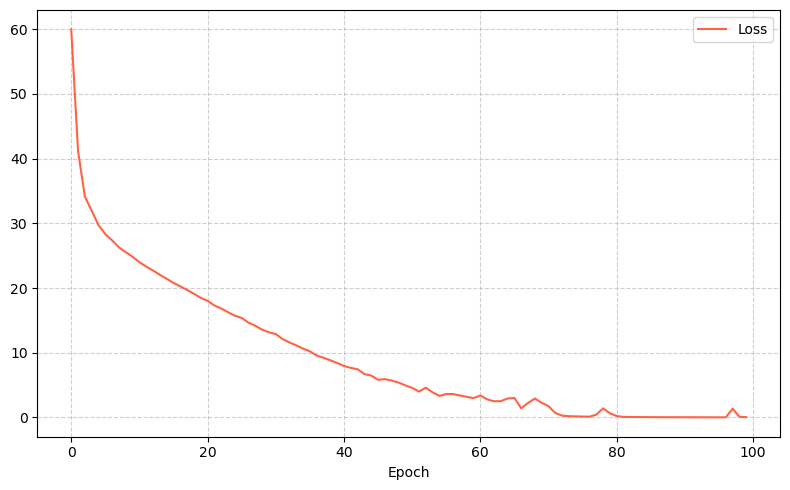

In [17]:
history_loss = np.load(f'models/{MODEL_NAME}/history_loss.npy')
plt.figure(figsize=(8, 5))
plt.plot(history_loss, linestyle='-', color='tomato', label="Loss")
# plt.title(title)
plt.xlabel("Epoch")
# plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
